# Code for Section 7.2 Market views vs stress-tests

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Specify prior parameters
means = np.array([0.04, 0.1])
vols = np.array([0.1, 0.2])
corr = np.array([[1, -0.3], [-0.3, 1]])
covariances = np.diag(vols) @ corr @ np.diag(vols)

In [3]:
# Simulate log-normal returns
S = 10000
np.random.seed(1337)
log_return = np.random.multivariate_normal(means, covariances, S)
discrete_return = pd.DataFrame(
    np.exp(log_return - np.diag(np.cov(log_return.T)) / 2) - 1,
    columns=['Bonds', 'Equities'])

In [4]:
# Validate simulation
ft.simulation_moments(100 * discrete_return)

,Mean,Volatility,Skewness,Kurtosis
Bonds,4.094294,10.259953,0.291147,3.207722
Equities,10.475701,22.039534,0.562900,3.544531


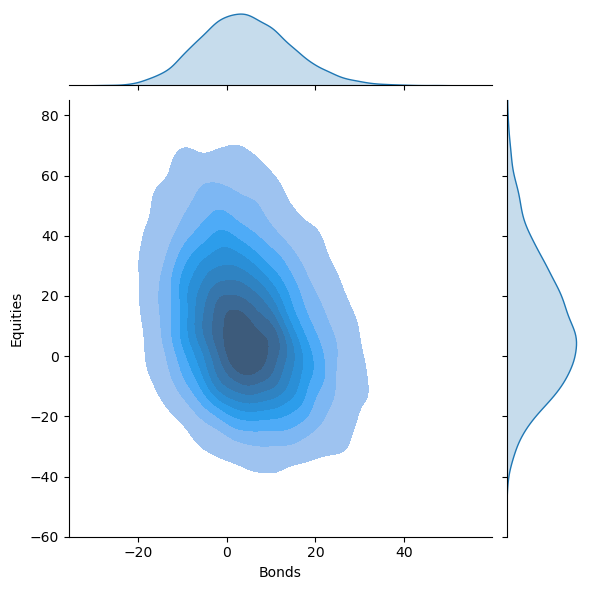

In [5]:
# Joint plot (Figure 7.2.1)
sns.jointplot(data=100 * discrete_return, x='Bonds', y='Equities', kind='kde', fill=True, ylim=[-60, 85])
plt.show()

# View example
The below example implements a view on equities expected return and volatility.

In [6]:
A = np.ones((1, S))
A = np.vstack((A, discrete_return.values[:, 1]))
A = np.vstack((A, (discrete_return.values[:, 1] - 0.075)**2))
b = np.array([[1., 0.075, 0.275**2]]).T

In [7]:
p = np.ones((S, 1)) / S
q_view = ft.entropy_pooling(p, A, b)
relative_entropy_view = q_view.T @ (np.log(q_view) - np.log(p))
effective_number_scenarios_view = np.exp(-relative_entropy_view)
print(f'Effective number of scenarios view = {np.round(effective_number_scenarios_view[0, 0] * 100, 2)}%.')
print(f'Relative entropy view = {np.round(relative_entropy_view[0, 0] * 100, 2)}%.')

Effective number of scenarios view = 93.16%.
Relative entropy view = 7.08%.


In [8]:
# Validate view implementation
np.round(ft.simulation_moments(100 * discrete_return, p=q_view), 3)

,Mean,Volatility,Skewness,Kurtosis
Bonds,4.663,10.487,0.287,3.232
Equities,7.500,27.500,1.384,6.616


# Stress-test example
The below example implements a stress-test view for the 60/40 portfolio. Specifically, we specify the view that the expected return of the portfolio is the 90%-CVaR, while the correlation between bonds and equities increases to 30% from approximately -30%.

In [9]:
exposures = np.array([[0.4], [0.6]])
portfolio_cvar = ft.portfolio_cvar(exposures, discrete_return, alpha=0.9, demean=False)
portfolio_return = discrete_return @ exposures
return_aggregated = pd.DataFrame(
    np.hstack((discrete_return, portfolio_return)),
    columns=['Bonds', 'Equities', 'Portfolio'])

In [10]:
# C0 views
A0 = np.ones((1, S))
A0 = np.vstack((A0, return_aggregated.values[:, 2]))
b0 = np.array([[1., -portfolio_cvar]]).T
q0 = ft.entropy_pooling(p, A0, b0)

In [11]:
relative_entropy_0 = q0.T @ (np.log(q0) - np.log(p))
effective_number_scenarios_0 = np.exp(-relative_entropy_0)
print(f'Effective number of scenarios intermediate stress-test = {np.round(effective_number_scenarios_0[0, 0] * 100, 2)}%.')
print(f'Relative entropy intermediate stress-test = {np.round(relative_entropy_0[0, 0] * 100, 2)}%.')

Effective number of scenarios intermediate stress-test = 20.03%.
Relative entropy intermediate stress-test = 160.81%.


In [12]:
# Validate that portfolio expected return is equal to 90% CVaR
stats0 = ft.simulation_moments(return_aggregated, q0)
display(np.round(ft.simulation_moments(100 * return_aggregated, q0), 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}.')

,Mean,Volatility,Skewness,Kurtosis
Bonds,1.232,9.657,0.202,3.181
Equities,-20.295,13.977,0.491,3.169
Portfolio,-11.684,8.822,0.082,3.405


Portfolio 90%-CVaR = 11.684.


In [13]:
# C4 (correlation) views with updated means and volatilities
A4 = np.ones((1, S))
A4 = np.vstack((A4, return_aggregated.values[:, 0:2].T))  # Means
A4 = np.vstack((A4, (return_aggregated.values[:, 0:2].T - stats0['Mean'].values[0:2][:, np.newaxis])**2))  # Volatilities
A4 = np.vstack((A4, (return_aggregated.values[:, 0] - stats0['Mean'].values[0]) * (return_aggregated.values[:, 1] - stats0['Mean'].values[1]) /
                    (stats0['Volatility'].values[0] * stats0['Volatility'].values[1])))  # Correlation
b4 = np.array([[1., *stats0['Mean'].iloc[0:2], *stats0['Volatility'].iloc[0:2]**2, 0.30]]).T

In [14]:
q_stress = ft.entropy_pooling(p, A4, b4)
relative_entropy_stress = q_stress.T @ (np.log(q_stress) - np.log(p))
effective_number_scenarios_stress = np.exp(-relative_entropy_stress)
print(f'Effective number of scenarios stress-test = {np.round(effective_number_scenarios_stress[0, 0] * 100, 2)}%.')
print(f'Relative entropy stress-test = {np.round(relative_entropy_stress[0, 0] * 100, 2)}%.')

Effective number of scenarios stress-test = 18.5%.
Relative entropy stress-test = 168.74%.


In [15]:
# Validate final posterior values
stats_q = ft.simulation_moments(return_aggregated, q_stress)
display(np.round(ft.simulation_moments(100 * return_aggregated, q0), 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}.')

,Mean,Volatility,Skewness,Kurtosis
Bonds,1.232,9.657,0.202,3.181
Equities,-20.295,13.977,0.491,3.169
Portfolio,-11.684,8.822,0.082,3.405


Portfolio 90%-CVaR = 11.684.


In [16]:
# Validate final posterior correlations
ft.correlation_matrix(return_aggregated, q_stress)

,0,1,2
"(0, Bonds)",1.000000,0.300000,0.623416
"(1, Equities)",0.300000,1.000000,0.932901
"(2, Portfolio)",0.623416,0.932901,1.000000


# Joint plot exercise for the readers
Try to replicate Figure 7.2.2 using sns.jointplot() by adding more arguments to the function

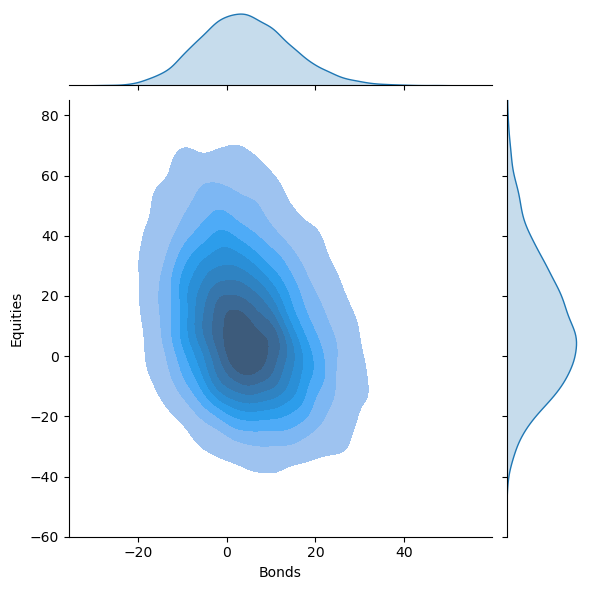

In [17]:
sns.jointplot(data=100 * discrete_return, x='Bonds', y='Equities', kind='kde', fill=True, ylim=[-60, 85])
plt.show()